# **Libraries**

In [1]:
# Installing pandas and other necessary libraries
!pip install pandas
!pip install transformers==4.29.2 datasets scikit-learn accelerate==0.21.0 lime shap bertviz


# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset, Dataset, DatasetDict
import torch
from torch.utils.data import DataLoader
import lime
from lime.lime_text import LimeTextExplainer
import shap
from sklearn.utils.class_weight import compute_class_weight

# Verifying installation
import transformers
import datasets
import sklearn
import accelerate

print(f"Pandas version: {pd.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"Datasets version: {datasets.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Accelerate version: {accelerate.__version__}")





     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3

# **Dataset**

In [2]:
# Loading the "sexismreddit" dataset from Hugging Face
dataset = load_dataset("natural-lang-processing/sexismreddit")

# Converting the train split to a Pandas DataFrame
df_train = pd.DataFrame(dataset['train'])

# Displaying the first few rows to understand the structure
print(df_train.head())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/14000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4000 [00:00<?, ? examples/s]

                  rewire_id  \
0  sexism2022_english-16993   
1  sexism2022_english-13149   
2  sexism2022_english-13021   
3  sexism2022_english-14998   
4   sexism2022_english-7228   

                                                text label_sexist  \
0                            Then, she's a keeper. 😉   not sexist   
1  This is like the Metallica video where the poo...   not sexist   
2                                             woman?   not sexist   
3  Unlicensed day care worker reportedly tells co...   not sexist   
4  [USER] Leg day is easy. Hot girls who wear min...       sexist   

  label_category                         label_vector  split  
0           none                                 none  train  
1           none                                 none  train  
2           none                                 none  train  
3           none                                 none  train  
4   3. animosity  3.3 backhanded gendered compliments  train  


In [3]:
# Inspecting the dataset structure
print(df_train.columns)
print(df_train['label_sexist'].unique())
print(df_train['label_category'].unique())

Index(['rewire_id', 'text', 'label_sexist', 'label_category', 'label_vector',
       'split'],
      dtype='object')
['not sexist' 'sexist']
['none' '3. animosity' '2. derogation' '4. prejudiced discussions'
 '1. threats, plans to harm and incitement']


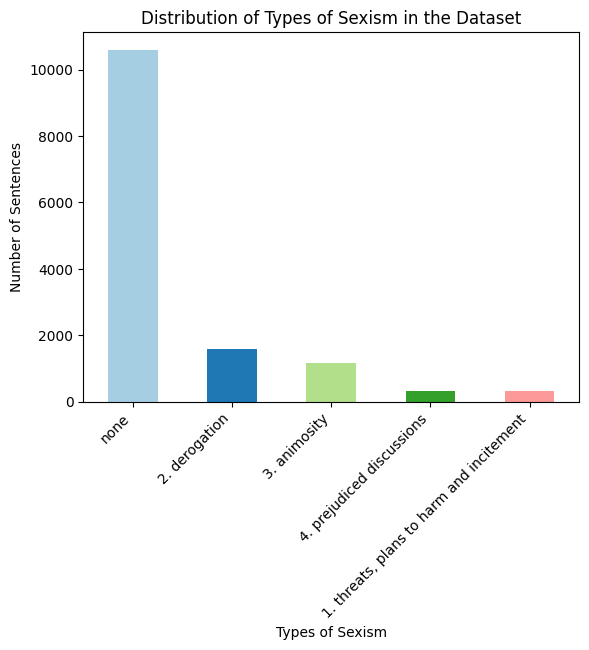

In [4]:
# Visualization of the target class distribution based on label_category
train_class_distribution = df_train['label_category'].value_counts()

# Plotting
fig, ax = plt.subplots()
train_class_distribution.plot(kind='bar', color=plt.cm.Paired.colors)
plt.xlabel('Types of Sexism')
plt.ylabel('Number of Sentences')
plt.title('Distribution of Types of Sexism in the Dataset')
plt.xticks(rotation=45, ha="right")
plt.show()

In [5]:
# Checking the distribution of 'label_sexist' in the train split
train_class_distribution = df_train['label_sexist'].value_counts()

# Calculating the minimum class count among all labels
min_class_count = min(train_class_distribution)

# Sampling the minimum class count from each class to balance the dataset
df_train_balanced = df_train.groupby('label_sexist').apply(lambda x: x.sample(min_class_count)).reset_index(drop=True)

# Checking the new distribution
train_class_distribution_balanced = df_train_balanced['label_sexist'].value_counts()
print(train_class_distribution_balanced)

label_sexist
not sexist    3398
sexist        3398
Name: count, dtype: int64


# **Baseline model (Logistical regression)**

In [11]:
# Sampling 700 examples for training, 200 for validation, and 100 for testing
df_train_sampled = df_train_balanced.sample(n=700, random_state=42)
df_validation_sampled = df_train_balanced.sample(n=200, random_state=42)


In [12]:
# Creating a DatasetDict from the sampled data
dataset_dict = DatasetDict({
    'train': Dataset.from_pandas(df_train_sampled),
    'validation': Dataset.from_pandas(df_validation_sampled)
})


In [13]:
# Printing the unique values in label_category to ensure they match the label_map
print(df_train_sampled['label_category'].unique())

['1. threats, plans to harm and incitement' 'none' '3. animosity'
 '2. derogation' '4. prejudiced discussions']


In [14]:
# Preparing data for the baseline model
X_train, y_train = df_train_sampled['text'], df_train_sampled['label_category']
X_val, y_val = df_validation_sampled['text'], df_validation_sampled['label_category']
X_test, y_test = df_test_sampled['text'], df_test_sampled['label_category']

In [15]:
# Tokenizing and train the baseline model
model_baseline = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=1000))
model_baseline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [16]:
# Evaluating the baseline model
y_pred_baseline = model_baseline.predict(X_test)
print("Baseline Model Evaluation:")
print(classification_report(y_test, y_pred_baseline))

Baseline Model Evaluation:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       0.00      0.00      0.00         5
                           2. derogation       0.96      0.83      0.89        29
                            3. animosity       1.00      0.40      0.57        15
               4. prejudiced discussions       0.00      0.00      0.00         4
                                    none       0.68      1.00      0.81        47

                                accuracy                           0.77       100
                               macro avg       0.53      0.45      0.45       100
                            weighted avg       0.75      0.77      0.72       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
from sklearn.model_selection import cross_val_predict

# Perform cross-validation
y_pred_cv = cross_val_predict(model_baseline, X_train, y_train, cv=5)

# Evaluating the baseline model with cross-validation
print("Baseline Model Cross-Validation Evaluation:")
print(classification_report(y_train, y_pred_cv))

Baseline Model Cross-Validation Evaluation:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       0.00      0.00      0.00        27
                           2. derogation       0.46      0.20      0.28       176
                            3. animosity       0.00      0.00      0.00       115
               4. prejudiced discussions       0.00      0.00      0.00        28
                                    none       0.55      0.95      0.70       354

                                accuracy                           0.53       700
                               macro avg       0.20      0.23      0.20       700
                            weighted avg       0.39      0.53      0.42       700



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
from sklearn.utils.class_weight import compute_class_weight

# Computing class weights
class_weights = compute_class_weight(class_weight='balanced', classes=y_train.unique(), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(y_train.unique(), class_weights)}

# Training the baseline model with class weights
model_baseline = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=1000, class_weight=class_weights_dict))
model_baseline.fit(X_train, y_train)

# Evaluating the baseline model
y_pred_baseline = model_baseline.predict(X_test)
print("Baseline Model Evaluation with Class Weights:")
print(classification_report(y_test, y_pred_baseline))


Baseline Model Evaluation with Class Weights:
                                          precision    recall  f1-score   support

1. threats, plans to harm and incitement       1.00      1.00      1.00         5
                           2. derogation       0.91      1.00      0.95        29
                            3. animosity       0.94      1.00      0.97        15
               4. prejudiced discussions       1.00      1.00      1.00         4
                                    none       1.00      0.91      0.96        47

                                accuracy                           0.96       100
                               macro avg       0.97      0.98      0.97       100
                            weighted avg       0.96      0.96      0.96       100



# **DistilBERT**

# **Re-loading dataset**

In [19]:
# Loading the "sexismreddit" dataset from Hugging Face
dataset = load_dataset("natural-lang-processing/sexismreddit")

# Converting the train split to a Pandas DataFrame
df_train = pd.DataFrame(dataset['train'])

# Displaying the first few rows to understand the structure
print(df_train.head())

                  rewire_id  \
0  sexism2022_english-16993   
1  sexism2022_english-13149   
2  sexism2022_english-13021   
3  sexism2022_english-14998   
4   sexism2022_english-7228   

                                                text label_sexist  \
0                            Then, she's a keeper. 😉   not sexist   
1  This is like the Metallica video where the poo...   not sexist   
2                                             woman?   not sexist   
3  Unlicensed day care worker reportedly tells co...   not sexist   
4  [USER] Leg day is easy. Hot girls who wear min...       sexist   

  label_category                         label_vector  split  
0           none                                 none  train  
1           none                                 none  train  
2           none                                 none  train  
3           none                                 none  train  
4   3. animosity  3.3 backhanded gendered compliments  train  


In [20]:
# Inspecting the dataset structure
print(df_train.columns)
print(df_train['label_sexist'].unique())
print(df_train['label_category'].unique())

Index(['rewire_id', 'text', 'label_sexist', 'label_category', 'label_vector',
       'split'],
      dtype='object')
['not sexist' 'sexist']
['none' '3. animosity' '2. derogation' '4. prejudiced discussions'
 '1. threats, plans to harm and incitement']


In [21]:
# Checking the distribution of 'label_sexist' in the train split
train_class_distribution = df_train['label_sexist'].value_counts()

# Calculating the minimum class count among all labels
min_class_count = min(train_class_distribution)

# Sampling the minimum class count from each class to balance the dataset
df_train_balanced = df_train.groupby('label_sexist').apply(lambda x: x.sample(min_class_count)).reset_index(drop=True)

# Checking the new distribution
train_class_distribution_balanced = df_train_balanced['label_sexist'].value_counts()
print(train_class_distribution_balanced)

label_sexist
not sexist    3398
sexist        3398
Name: count, dtype: int64


# **Tokenization**

In [22]:
# Sampling 900 examples for training and 250 examples for validation
df_train_sampled = df_train_balanced.sample(n=700, random_state=42)
df_validation_sampled = df_train_balanced.sample(n=200, random_state=42)

# Create a DatasetDict from the sampled data
dataset_dict = DatasetDict({
    'train': Dataset.from_pandas(df_train_sampled),
    'validation': Dataset.from_pandas(df_validation_sampled)
})

# Print the unique values in label_category to ensure they match the label_map
print(df_train_sampled['label_category'].unique())

['2. derogation' 'none' '4. prejudiced discussions' '3. animosity'
 '1. threats, plans to harm and incitement']


In [24]:
# Tokenizer and Model Initialization
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

# Function to process labels and tokenize text
def process_data(examples):
    label_map = {
        "none": 0,
        "3. animosity": 1,
        "2. derogation": 2,
        "4. prejudiced discussions": 3,
        "1. threats, plans to harm and incitement": 4
    }
    encodings = tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)
    encodings['labels'] = [label_map[label] for label in examples["label_category"]]
    return encodings

# Applying processing function to the dataset
encoded_dataset = dataset_dict.map(process_data, batched=True)

# Converting to PyTorch tensors
encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Checking dataset sizes
print(f"Training examples: {len(encoded_dataset['train'])}")
print(f"Validation examples: {len(encoded_dataset['validation'])}")

### had problems with mapping labels categories

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.weight', 'pre_classifier.

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Training examples: 700
Validation examples: 200


In [25]:
# DataLoader
train_dataloader = DataLoader(encoded_dataset['train'], batch_size=16, shuffle=True)
validation_dataloader = DataLoader(encoded_dataset['validation'], batch_size=16)

# **DistilBERT training**

In [26]:
# Training Arguments with Learning Rate Scheduler
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,  # Increased number of epochs from the first attempts
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=3e-5,  # Adjusted the learning rate as well
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    lr_scheduler_type="linear",  # Linear learning rate scheduler
)

# Metrics Function
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(labels, pred)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, pred, average='weighted', zero_division=1)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Trainer Initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['validation'],
    compute_metrics=compute_metrics
)

# Training the Model
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


TrainOutput(global_step=440, training_loss=0.9334232007915323, metrics={'train_runtime': 137.8946, 'train_samples_per_second': 50.763, 'train_steps_per_second': 3.191, 'total_flos': 231830350080000.0, 'train_loss': 0.9334232007915323, 'epoch': 10.0})

In [29]:
# Saving the trained model and tokenizer
model.save_pretrained('./trained_model')
tokenizer.save_pretrained('./trained_model')

('./trained_model/tokenizer_config.json',
 './trained_model/special_tokens_map.json',
 './trained_model/vocab.txt',
 './trained_model/added_tokens.json')

In [32]:
# Loading the trained model and tokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Loading the trained model and tokenizer
model_directory = './trained_model'

tokenizer = AutoTokenizer.from_pretrained(model_directory)
model = AutoModelForSequenceClassification.from_pretrained(model_directory)

# Ensuring model is on the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

df_test = pd.DataFrame(dataset['test'])

# Creating a DatasetDict from the test data
dataset_dict = DatasetDict({
    'test': Dataset.from_pandas(df_test)
})

# Function to process labels and tokenize text
def process_data(examples):
    label_map = {
        "none": 0,
        "3. animosity": 1,
        "2. derogation": 2,
        "4. prejudiced discussions": 3,
        "1. threats, plans to harm and incitement": 4
    }
    encodings = tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)
    encodings['labels'] = [label_map[label] for label in examples["label_category"]]
    return encodings

# Applying processing function to the test dataset
encoded_test_dataset = dataset_dict.map(process_data, batched=True)

# Convert to PyTorch tensors
encoded_test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Evaluate the model on the test set
trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics
)

test_results = trainer.evaluate(encoded_test_dataset['test'])

print("Test Set Evaluation Results:")
print(test_results)



Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Test Set Evaluation Results:
{'eval_loss': 0.985414445400238, 'eval_accuracy': 0.704, 'eval_precision': 0.7277309373859794, 'eval_recall': 0.704, 'eval_f1': 0.7117316216567215, 'eval_runtime': 15.3394, 'eval_samples_per_second': 260.767, 'eval_steps_per_second': 32.596}


In [34]:
# Function to make predictions and format output
def classify_text(text, model, tokenizer):
    model.eval()  # Set the model to evaluation mode
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to the device
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class = torch.argmax(logits, dim=1).item()

    # Mapping for sexism detection
    sexism_map = {
        0: "This sentence is non-Sexist",
        1: "This sentence is Sexist",
        2: "This sentence is Sexist",
        3: "This sentence is Sexist",
        4: "This sentence is Sexist"
    }

    # Detailed mapping for type of sexism
    detailed_label_map = {
        0: "This sentence is non-Sexist",
        1: "This sentence exhibits animosity",
        2: "This sentence exhibits derogation",
        3: "This sentence involves prejudiced discussions",
        4: "This sentence contains threats, plans to harm and incitement"
    }

    sexism_result = sexism_map[predicted_class]
    detailed_result = detailed_label_map[predicted_class]

    print("\nInput Text:")
    print(text)
    print("\nClassification Result:")
    print(sexism_result)
    if predicted_class != 0:
        print("Type of Sexism:")
        print(detailed_result)

# Example usage
test_str = "Women are a waste of space."
classify_text(test_str, model, tokenizer)


Input Text:
Women are a waste of space.

Classification Result:
This sentence is Sexist
Type of Sexism:
This sentence exhibits derogation


# **RoBERTa**

# **Re-loading dataset**

In [44]:
# Loading the "sexismreddit" dataset from Hugging Face
dataset = load_dataset("natural-lang-processing/sexismreddit")

# Converting the train split to a Pandas DataFrame
df_train = pd.DataFrame(dataset['train'])

# Displaying the first few rows to understand the structure
print(df_train.head())

                  rewire_id  \
0  sexism2022_english-16993   
1  sexism2022_english-13149   
2  sexism2022_english-13021   
3  sexism2022_english-14998   
4   sexism2022_english-7228   

                                                text label_sexist  \
0                            Then, she's a keeper. 😉   not sexist   
1  This is like the Metallica video where the poo...   not sexist   
2                                             woman?   not sexist   
3  Unlicensed day care worker reportedly tells co...   not sexist   
4  [USER] Leg day is easy. Hot girls who wear min...       sexist   

  label_category                         label_vector  split  
0           none                                 none  train  
1           none                                 none  train  
2           none                                 none  train  
3           none                                 none  train  
4   3. animosity  3.3 backhanded gendered compliments  train  


In [45]:
# Checking the distribution of 'label_sexist' in the train split
train_class_distribution = df_train['label_sexist'].value_counts()

# Calculating the minimum class count among all labels
min_class_count = min(train_class_distribution)

# Sampling the minimum class count from each class to balance the dataset
df_train_balanced = df_train.groupby('label_sexist').apply(lambda x: x.sample(min_class_count)).reset_index(drop=True)

# Checking the new distribution
train_class_distribution_balanced = df_train_balanced['label_sexist'].value_counts()
print(train_class_distribution_balanced)

label_sexist
not sexist    3398
sexist        3398
Name: count, dtype: int64


In [47]:
# Sampling 900 examples for training, 250 for validation
df_train_sampled = df_train_balanced.sample(n=900, random_state=42)
df_validation_sampled = df_train_balanced.sample(n=250, random_state=42)

# **Tokenization**

In [48]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

# Loading the RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Defining a function to process labels and tokenize text
def process_data(examples):
    label_map = {
        "none": 0,
        "3. animosity": 1,
        "2. derogation": 2,
        "4. prejudiced discussions": 3,
        "1. threats, plans to harm and incitement": 4
    }
    encodings = tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)
    encodings['labels'] = [label_map[label] for label in examples["label_category"]]
    return encodings

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [49]:
# Converting the sampled DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(df_train_sampled)
validation_dataset = Dataset.from_pandas(df_validation_sampled)

In [50]:
# Applying the processing function to the datasets
encoded_train_dataset = train_dataset.map(process_data, batched=True)
encoded_validation_dataset = validation_dataset.map(process_data, batched=True)
encoded_test_dataset = test_dataset.map(process_data, batched=True)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/250 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [51]:
# Setting the format of the datasets to PyTorch tensors
encoded_train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
encoded_validation_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
encoded_test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# **Training**

In [52]:
# Loading the RoBERTa model
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=5)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should pr

In [53]:
# Defining training arguments
training_args = TrainingArguments(
    output_dir='./roberta_results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=3e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./roberta_logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    lr_scheduler_type="linear",
)

# Defining metrics function
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(labels, pred)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, pred, average='weighted', zero_division=1)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Initializing the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_validation_dataset,
    compute_metrics=compute_metrics
)

# Training the RoBERTa model
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


TrainOutput(global_step=570, training_loss=0.8019119938214619, metrics={'train_runtime': 386.5716, 'train_samples_per_second': 23.282, 'train_steps_per_second': 1.475, 'total_flos': 592015820544000.0, 'train_loss': 0.8019119938214619, 'epoch': 10.0})

In [56]:
# Save the trained model and tokenizer
model.save_pretrained('./trained_model_rob')
tokenizer.save_pretrained('./trained_model_rob')

('./trained_model_rob/tokenizer_config.json',
 './trained_model_rob/special_tokens_map.json',
 './trained_model_rob/vocab.json',
 './trained_model_rob/merges.txt',
 './trained_model_rob/added_tokens.json')

In [57]:
# Loading the trained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('./trained_model_rob')
model = AutoModelForSequenceClassification.from_pretrained('./trained_model_rob')

df_test = pd.DataFrame(dataset['test'])

# Create a DatasetDict from the test data
dataset_dict = DatasetDict({
    'test': Dataset.from_pandas(df_test)
})

# Function to process labels and tokenize text
def process_data(examples):
    label_map = {
        "none": 0,
        "3. animosity": 1,
        "2. derogation": 2,
        "4. prejudiced discussions": 3,
        "1. threats, plans to harm and incitement": 4
    }
    encodings = tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)
    encodings['labels'] = [label_map[label] for label in examples["label_category"]]
    return encodings

# Applying processing function to the test dataset
encoded_test_dataset = dataset_dict.map(process_data, batched=True)

# Converting to PyTorch tensors
encoded_test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Metrics Function
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(labels, pred)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, pred, average='weighted', zero_division=1)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Evaluating the model on the test set
trainer = Trainer(
    model=model,
    compute_metrics=compute_metrics
)

test_results = trainer.evaluate(encoded_test_dataset['test'])

print("Test Set Evaluation Results:")
print(test_results)



Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Test Set Evaluation Results:
{'eval_loss': 1.3326499462127686, 'eval_accuracy': 0.672, 'eval_precision': 0.7607458381032693, 'eval_recall': 0.672, 'eval_f1': 0.7059115559661803, 'eval_runtime': 27.7333, 'eval_samples_per_second': 144.231, 'eval_steps_per_second': 18.029}


In [61]:
# Function to make predictions and format output
def classify_text(text, model, tokenizer):
    model.eval()  # Setting the model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Moving the model to the device
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {key: value.to(device) for key, value in inputs.items()}  # Moving inputs to the device
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class = torch.argmax(logits, dim=1).item()

    # Mapping for sexism detection
    sexism_map = {
        0: "This sentence is non-Sexist",
        1: "This sentence is Sexist",
        2: "This sentence is Sexist",
        3: "This sentence is Sexist",
        4: "This sentence is Sexist"
    }

    # Detailed mapping for type of sexism
    detailed_label_map = {
        0: "This sentence is non-Sexist",
        1: "This sentence exhibits animosity",
        2: "This sentence exhibits derogation",
        3: "This sentence involves prejudiced discussions",
        4: "This sentence contains threats, plans to harm and incitement"
    }

    sexism_result = sexism_map[predicted_class]
    detailed_result = detailed_label_map[predicted_class]

    print("\nInput Text:")
    print(text)
    print("\nClassification Result:")
    print(sexism_result)
    if predicted_class != 0:
        print("Type of Sexism:")
        print(detailed_result)

# Example usage
test_str = "A woman is as dumb as a stick."
classify_text(test_str, model, tokenizer)


Input Text:
A woman is as dumb as a stick.

Classification Result:
This sentence is Sexist
Type of Sexism:
This sentence exhibits derogation


# **LIME**

In [72]:
### LIME Explanation
#This cell uses the LIME library to explain the model's predictions.

import torch
from lime.lime_text import LimeTextExplainer

# Setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to predict probabilities for LIME
def predict_proba(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs).logits
        probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
    return probs

# Initializing the LIME explainer
explainer = LimeTextExplainer(class_names=["none", "animosity", "derogation", "prejudiced discussions", "threats, plans to harm and incitement"])

# Example text
test_str = "We should allow beating women up."

# Generating LIME explanation
exp = explainer.explain_instance(test_str, predict_proba, num_features=10)
exp.show_in_notebook(text=True)

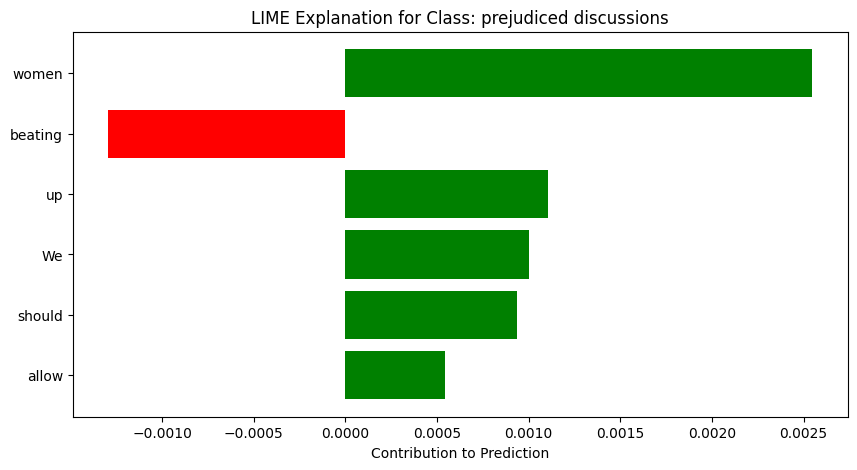

In [71]:
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt

# Setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to predict probabilities for LIME
def predict_proba(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs).logits
        probs = torch.nn.functional.softmax(outputs, dim=1).cpu().numpy()
    return probs

# Initializing the LIME explainer
explainer = LimeTextExplainer(class_names=["none", "animosity", "derogation", "prejudiced discussions", "threats, plans to harm and incitement"])

# Example text
test_str = "We should allow beating women up."

# Generating LIME explanation
exp = explainer.explain_instance(test_str, predict_proba, num_features=10)

# Getting the predicted class
predicted_proba = predict_proba([test_str])
predicted_class = predicted_proba.argmax(axis=1)[0]

# Custom function to plot the LIME explanation with the correct class names
def custom_plot(exp, class_names, prediction):
    fig, ax = plt.subplots(figsize=(10, 5))

    values = exp.as_list()
    values.reverse()  # reverse to have the highest contributing factor at the top

    bar_colors = ['green' if v[1] > 0 else 'red' for v in values]
    ax.barh([v[0] for v in values], [v[1] for v in values], color=bar_colors)
    ax.set_xlabel('Contribution to Prediction')
    ax.set_title(f'LIME Explanation for Class: {class_names[prediction]}')

    plt.show()

# Displaying the custom plot
custom_plot(exp, explainer.class_names, predicted_class)

